<a href="https://colab.research.google.com/github/gestured/Cat_vs_Dog_Classifier/blob/main/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from tensorflow.keras import layers , Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/drive/MyDrive/Cats_vs_Dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_wghts = '/content/drive/MyDrive/Cats_vs_Dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrain_model = InceptionV3(
                    input_shape = (150,150,3),
                    include_top = False,
                    weights = None
                 )

pretrain_model.load_weights(local_wghts)

for layer in pretrain_model.layers:
  layer.trainable = False

last_layer = pretrain_model.get_layer('mixed7')
print('Last Layer Output Shape : ' , last_layer.output_shape)

last_output = last_layer.output

--2021-04-23 15:26:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.164.176, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/drive/MyDrive/Cats_vs_Dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/drive/MyDr 100%[===================>]  83.84M  74.2MB/s    in 1.1s    

2021-04-23 15:26:47 (74.2 MB/s) - ‘/content/drive/MyDrive/Cats_vs_Dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Last Layer Output Shape :  (None, 7, 7, 768)


In [2]:
from tensorflow.keras.optimizers import RMSprop

model = layers.Flatten()(last_output)

model = layers.Dense(1024 , activation='relu')(model)

model = layers.Dropout(0.2)(model)

model = layers.Dense(1 , activation='sigmoid')(model)

final_model = Model(pretrain_model.input , model)

final_model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [29]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-04-23 15:33:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.217.8.16, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   143MB/s    in 0.5s    

2021-04-23 15:33:47 (143 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
history = final_model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 53s - loss: 0.3505 - accuracy: 0.8720 - val_loss: 0.1253 - val_accuracy: 0.9470
Epoch 2/20
100/100 - 17s - loss: 0.2243 - accuracy: 0.9175 - val_loss: 0.0988 - val_accuracy: 0.9660
Epoch 3/20
100/100 - 17s - loss: 0.1864 - accuracy: 0.9275 - val_loss: 0.0995 - val_accuracy: 0.9640
Epoch 4/20
100/100 - 18s - loss: 0.1892 - accuracy: 0.9300 - val_loss: 0.1000 - val_accuracy: 0.9680
Epoch 5/20
100/100 - 18s - loss: 0.1792 - accuracy: 0.9335 - val_loss: 0.1630 - val_accuracy: 0.9460
Epoch 6/20
100/100 - 17s - loss: 0.1914 - accuracy: 0.9325 - val_loss: 0.1886 - val_accuracy: 0.9470
Epoch 7/20
100/100 - 17s - loss: 0.1783 - accuracy: 0.9375 - val_loss: 0.1091 - val_accuracy: 0.9660
Epoch 8/20
100/100 - 17s - loss: 0.1657 - accuracy: 0.9390 - val_loss: 0.2913 - val_accuracy: 0.9320
Epoch 9/20
100/100 - 17s - loss: 0.1779 - accuracy: 0.9420 - val_loss: 0.1206 - val_accuracy: 0.9630
Epoch 10/20
100/100 - 17s - loss: 0.1695 - accuracy: 0.9445 - val_loss: 0.1224 - val_accura

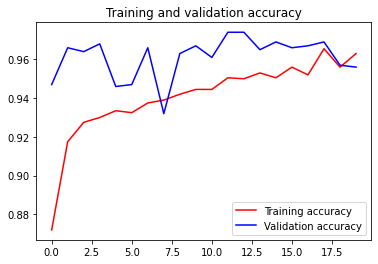

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [8]:
final_model.save('/content/drive/MyDrive/Cats_vs_Dogs/dogvcat.h5')

In [23]:
import numpy as np
from google.colab.patches import cv2_imshow
def test_image(inp_img):
  image = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(150,150))
  cv2_imshow(image)
  img_array = np.array(image)
  img_array=img_array/255
  image_test = np.expand_dims(img_array, axis=0)
  pred_1=final_model.predict(image_test)
  if round(pred_1[0][0]) == 0.0:
    print("CAT")
  else:
    print("DOG")

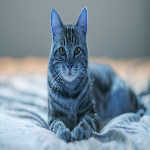

CAT


In [24]:
import cv2
mg = cv2.imread('/cat.jpg')
test_image(mg)

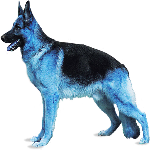

DOG


In [25]:
mg2 = cv2.imread('/German-shepherd.jpg')
test_image(mg2)

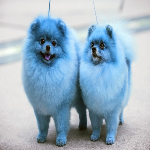

DOG


In [27]:
mg3 = cv2.imread('/dog.jpg')
test_image(mg3)

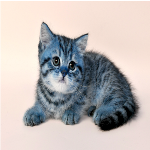

CAT


In [28]:
mg4 = cv2.imread('/cat.png')
test_image(mg4)